dict_keys(['train', 'validation', 'test'])
Size of train dataset:  (157252, 3)
Size of Validation dataset:  (5599, 3)
dict_keys(['headline', 'text', 'title'])
 Example of text:  If you're a photographer, keep all the necessary lens, cords, and batteries in the same quadrant of your home or studio. Paints should be kept with brushes, cleaner, and canvas, print supplies should be by the ink, etc. Make broader groups and areas for your supplies to make finding them easier, limiting your search to a much smaller area. Some ideas include:


Essential supplies area -- the things you use every day.
Inspiration and reference area.
Dedicated work area .
Infrequent or secondary supplies area, tucked out of the way.;
, This doesn't mean cleaning the entire studio, it just means keeping the area immediately around the desk, easel, pottery wheel, etc. clean each night. Discard trash or unnecessary materials and wipe down dirty surfaces. Endeavor to leave the workspace in a way that you can sit down

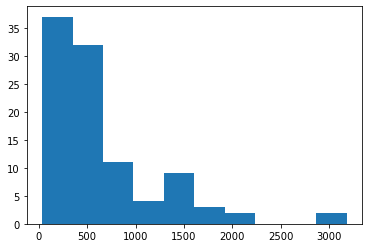

In [8]:
## Load Data from NLP Library
from nlp import load_dataset
dataset = load_dataset('wikihow', 'all', data_dir='data')
print(dataset.keys())
print("Size of train dataset: ", dataset['train'].shape)
print("Size of Validation dataset: ", dataset['validation'].shape)
## Look at Sample Examples
print(dataset['train'][0].keys())
print(" Example of text: ", dataset['train'][0]['text'])
print(" Example of Summary: ", dataset['train'][0]['headline'])
## Estimate Average Length of Text and Summary
tiny_dataset = dataset['train'].select(list(range(0, 100)))
text_len = []
summary_len=[]
for i in range(len(tiny_dataset)):
    example = tiny_dataset[i]
    text_example = example['text']
    text_example = text_example.replace('\n','')
    text_words = text_example.split()
    text_len.append(len(text_words))
    summary_example = example['headline']
    summary_example = summary_example.replace('\n','')
    summary_words = summary_example.split()
    summary_len.append(len(summary_words))
    
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(text_len)
plt.show()

In [24]:
import torch
from torch.utils.data import Dataset
import pytorch_lightning as pl

In [20]:
class wikihow(Dataset):
    def __init__(self, tokenizer, type_path, num_samples, input_length, output_length, print_text=False):         
        self.dataset =  load_dataset('wikihow', 'all', data_dir='data/', split=type_path)
        if num_samples:
            self.dataset = self.dataset.select(list(range(0, num_samples)))
        self.input_length = input_length
        self.tokenizer = tokenizer
        self.output_length = output_length
        self.print_text = print_text
  
    def __len__(self):
        return self.dataset.shape[0]
    
    def clean_text(self, text):
        text = text.replace('Example of text:', '')
        text = text.replace('Example of Summary:', '')
        text = text.replace('\n','')
        text = text.replace('``', '')
        text = text.replace('"', '')
        
        return text
    
    
    def convert_to_features(self, example_batch):
        # Tokenize contexts and questions (as pairs of inputs)
        
        if self.print_text:
            print("Input Text: ", self.clean_text(example_batch['text']))
#         input_ = self.clean_text(example_batch['text']) + " </s>"
#         target_ = self.clean_text(example_batch['headline']) + " </s>"
        
        input_ = self.clean_text(example_batch['text'])
        target_ = self.clean_text(example_batch['headline'])
        
        source = self.tokenizer.batch_encode_plus([input_], max_length=self.input_length, 
                                                     padding='max_length', truncation=True, return_tensors="pt")
        
        targets = self.tokenizer.batch_encode_plus([target_], max_length=self.output_length, 
                                                     padding='max_length', truncation=True, return_tensors="pt")
    
       
        return source, targets
  
    def __getitem__(self, index):
        source, targets = self.convert_to_features(self.dataset[index])
        
        source_ids = source["input_ids"].squeeze()
        target_ids = targets["input_ids"].squeeze()

        src_mask    = source["attention_mask"].squeeze()
        target_mask = targets["attention_mask"].squeeze()

        return {"source_ids": source_ids, "source_mask": src_mask, "target_ids": target_ids, "target_mask": target_mask}
        
  

In [22]:
class T5FineTuner(pl.LightningModule):
    def __init__(self, hparams):
        super(T5FineTuner, self).__init__()
        self.hparams = hparams        
        self.model = T5ForConditionalGeneration.from_pretrained(hparams.model_name_or_path)
        self.tokenizer = T5Tokenizer.from_pretrained(hparams.tokenizer_name_or_path)
        self.rouge_metric = load_metric('rouge') 
        
        if self.hparams.freeze_embeds:
            self.freeze_embeds()
        if self.hparams.freeze_encoder:
            self.freeze_params(self.model.get_encoder())
            assert_all_frozen(self.model.get_encoder())
            
            
        n_observations_per_split = {
            "train": self.hparams.n_train,
            "validation": self.hparams.n_val,
            "test": self.hparams.n_test,
        }
        self.n_obs = {k: v if v >= 0 else None for k, v in n_observations_per_split.items()}
        
    
    def freeze_params(self, model):
        for par in model.parameters():
            par.requires_grad = False
            
            
    def freeze_embeds(self):
        """Freeze token embeddings and positional embeddings for bart, just token embeddings for t5."""
        try:
            self.freeze_params(self.model.model.shared)
            for d in [self.model.model.encoder, self.model.model.decoder]:
                freeze_params(d.embed_positions)
                freeze_params(d.embed_tokens)
        except AttributeError:
            self.freeze_params(self.model.shared)
            for d in [self.model.encoder, self.model.decoder]:
                self.freeze_params(d.embed_tokens)
    
    def lmap(self, f, x):
        """list(map(f, x))"""
        return list(map(f, x))
    

    def is_logger(self):
        return self.trainer.proc_rank <= 0
    
    
    def parse_score(self, result):
        return {k: round(v.mid.fmeasure * 100, 4) for k, v in result.items()}
        
    def forward(
      self, input_ids, attention_mask=None, decoder_input_ids=None, decoder_attention_mask=None, lm_labels=None
  ):
        return self.model(
            input_ids,
            attention_mask=attention_mask,
            decoder_input_ids=decoder_input_ids,
            decoder_attention_mask=decoder_attention_mask,
            lm_labels=lm_labels,
    )

    def _step(self, batch):
        lm_labels = batch["target_ids"]
        lm_labels[lm_labels[:, :] == self.tokenizer.pad_token_id] = -100

        outputs = self(
            input_ids=batch["source_ids"],
            attention_mask=batch["source_mask"],
            lm_labels=lm_labels,
            decoder_attention_mask=batch['target_mask']
        )

        loss = outputs[0]

        return loss
    
    
    def ids_to_clean_text(self, generated_ids):
        gen_text = self.tokenizer.batch_decode(
            generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True
        )
        return self.lmap(str.strip, gen_text)
    
    
    def _generative_step(self, batch) :
        
        t0 = time.time()
        
        generated_ids = self.model.generate(
            batch["source_ids"],
            attention_mask=batch["source_mask"],
            use_cache=True,
            decoder_attention_mask=batch['target_mask'],
            max_length=150, 
            num_beams=2,
            repetition_penalty=2.5, 
            length_penalty=1.0, 
            early_stopping=True
        )
        preds = self.ids_to_clean_text(generated_ids)
        target = self.ids_to_clean_text(batch["target_ids"])
            
        gen_time = (time.time() - t0) / batch["source_ids"].shape[0]  
    
        loss = self._step(batch)
        base_metrics = {'val_loss': loss}
#         rouge: Dict = self.calc_generative_metrics(preds, target)
        summ_len = np.mean(self.lmap(len, generated_ids))
        base_metrics.update(gen_time=gen_time, gen_len=summ_len, preds=preds, target=target)
        self.rouge_metric.add_batch(preds, target)
        
#         rouge_results = self.rouge_metric.compute() 
#         rouge_dict = self.parse_score(rouge_results)
#         base_metrics.update(rouge1=rouge_dict['rouge1'], rougeL=rouge_dict['rougeL'])
        
        return base_metrics
    

    def training_step(self, batch, batch_idx):
        loss = self._step(batch)

        tensorboard_logs = {"train_loss": loss}
        return {"loss": loss, "log": tensorboard_logs}
  
    def training_epoch_end(self, outputs):
        avg_train_loss = torch.stack([x["loss"] for x in outputs]).mean()
        tensorboard_logs = {"avg_train_loss": avg_train_loss}
        return {"avg_train_loss": avg_train_loss, "log": tensorboard_logs, 'progress_bar': tensorboard_logs}

    def validation_step(self, batch, batch_idx):
        return self._generative_step(batch)
    
  
    def validation_epoch_end(self, outputs):
        
        avg_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
        tensorboard_logs = {"val_loss": avg_loss}
        
        rouge_results = self.rouge_metric.compute() 
        rouge_dict = self.parse_score(rouge_results)
    
        tensorboard_logs.update(rouge1=rouge_dict['rouge1'], rougeL=rouge_dict['rougeL'])
        
        ## Clear out the lists for next epoch
        self.target_gen= []
        self.prediction_gen=[]
        return {"avg_val_loss": avg_loss, 
                "rouge1" : rouge_results['rouge1'],
                "rougeL" : rouge_results['rougeL'],
                "log": tensorboard_logs, 'progress_bar': tensorboard_logs}

    def configure_optimizers(self):
        "Prepare optimizer and schedule (linear warmup and decay)"

        model = self.model
        no_decay = ["bias", "LayerNorm.weight"]
        optimizer_grouped_parameters = [
            {
                "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
                "weight_decay": self.hparams.weight_decay,
            },
            {
                "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
                "weight_decay": 0.0,
            },
        ]
        optimizer = AdamW(optimizer_grouped_parameters, lr=self.hparams.learning_rate, eps=self.hparams.adam_epsilon)
        self.opt = optimizer
        return [optimizer]
  
    def optimizer_step(self, epoch, batch_idx, optimizer, optimizer_idx, second_order_closure=None, using_native_amp=False):
        if self.trainer.use_tpu:
            xm.optimizer_step(optimizer)
        else:
            optimizer.step()
        optimizer.zero_grad()
        self.lr_scheduler.step()
  
    def get_tqdm_dict(self):
        tqdm_dict = {"loss": "{:.3f}".format(self.trainer.avg_loss), "lr": self.lr_scheduler.get_last_lr()[-1]}

        return tqdm_dict
    

    def train_dataloader(self):   
        n_samples = self.n_obs['train']
        train_dataset = get_dataset(tokenizer=self.tokenizer, type_path="train", num_samples=n_samples, args=self.hparams)
        dataloader = DataLoader(train_dataset, batch_size=self.hparams.train_batch_size, drop_last=True, shuffle=True, num_workers=4)
        t_total = (
            (len(dataloader.dataset) // (self.hparams.train_batch_size * max(1, self.hparams.n_gpu)))
            // self.hparams.gradient_accumulation_steps
            * float(self.hparams.num_train_epochs)
        )
        scheduler = get_linear_schedule_with_warmup(
            self.opt, num_warmup_steps=self.hparams.warmup_steps, num_training_steps=t_total
        )
        self.lr_scheduler = scheduler
        return dataloader

    def val_dataloader(self):
        n_samples = self.n_obs['validation']
        validation_dataset = get_dataset(tokenizer=self.tokenizer, type_path="validation", num_samples=n_samples, args=self.hparams)
        
        return DataLoader(validation_dataset, batch_size=self.hparams.eval_batch_size, num_workers=4)
    
    
    def test_dataloader(self):
        n_samples = self.n_obs['test']
        test_dataset = get_dataset(tokenizer=self.tokenizer, type_path="test", num_samples=n_samples, args=self.hparams)
        
        return DataLoader(test_dataset, batch_size=self.hparams.eval_batch_size, num_workers=4)

In [25]:
from transformers import AutoTokenizer, AutoModelWithLMHead

tokenizer = AutoTokenizer.from_pretrained("deep-learning-analytics/wikihow-t5-small")
model = AutoModelWithLMHead.from_pretrained("deep-learning-analytics/wikihow-t5-small")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

text = """"
Lack of fluids can lead to dry mouth, which is a leading cause of bad breath. Water
can also dilute any chemicals in your mouth or gut that are causing bad breath., Studies show that
eating 6 ounces of yogurt a day reduces the level of odor-causing compounds in the mouth. In
particular, look for yogurt containing the active bacteria Streptococcus thermophilus or
Lactobacillus bulgaricus., The abrasive nature of fibrous fruits and vegetables helps to clean
teeth, while the vitamins, antioxidants, and acids they contain improve dental health.Foods that can
be particularly helpful include:Apples — Apples contain vitamin C, which is necessary for health
gums, as well as malic acid, which helps to whiten teeth.Carrots — Carrots are rich in vitamin A,
which strengthens tooth enamel.Celery — Chewing celery produces a lot of saliva, which helps to
neutralize bacteria that cause bad breath.Pineapples — Pineapples contain bromelain, an enzyme that
cleans the mouth., These teas have been shown to kill the bacteria that cause bad breath and
plaque., An upset stomach can lead to burping, which contributes to bad breath. Don’t eat foods that
upset your stomach, or if you do, use antacids. If you are lactose intolerant, try lactase tablets.,
They can all cause bad breath. If you do eat them, bring sugar-free gum or a toothbrush and
toothpaste to freshen your mouth afterwards., Diets low in carbohydrates lead to ketosis — a state
in which the body burns primarily fat instead of carbohydrates for energy. This may be good for your
waistline, but it also produces chemicals called ketones, which contribute to bad breath.To stop the
problem, you must change your diet. Or, you can combat the smell in one of these ways:Drink lots of
water to dilute the ketones.Chew sugarless gum or suck on sugarless mints.Chew mint leaves.
"""

preprocess_text = text.strip().replace("\n","")
tokenized_text = tokenizer.encode(preprocess_text, return_tensors="pt").to(device)

summary_ids = model.generate(
            tokenized_text,
            max_length=150, 
            num_beams=2,
            repetition_penalty=2.5, 
            length_penalty=1.0, 
            early_stopping=True
        )

output = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

print ("\n\nSummarized text: \n",output)



Summarized text: 
 Drink water.Eat yogurt.Eat fibrous fruits and vegetables.Try teas.Eat lactose-intolerant foods.Eat sugar-free gum.Drink plenty of water.
